# 1. Include Libraries and Check GPU

In [1]:
import os
import wget

import tensorflow as tf

import object_detection
from object_detection.builders import model_builder
from object_detection.protos   import pipeline_pb2
from object_detection.utils    import config_util
from object_detection.utils    import label_map_util
from object_detection.utils    import visualization_utils as viz_utils

from google.protobuf import text_format

# Check whether the GPU is recognised
print(tf.config.list_physical_devices('GPU'))

# Change working directory
os.chdir(os.pardir)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Configure Model

In [2]:
CUSTOM_MODEL_NAME     = 'centernet_hg104_512x512_coco17_tpu-8' 
PRETRAINED_MODEL_NAME = 'centernet_hg104_512x512_coco17_tpu-8'
PRETRAINED_MODEL_URL  = 'http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_512x512_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME        = 'label_map.pbtxt'

labels = [{'name':'BikeLaneMarker', 'id':1}]

input_directory = os.path.join('data_sources', 'test1')
output_directory = os.path.join('data_sources', 'test1_out')


# 3. Create Directories

In [3]:
paths = {
    'WORKSPACE_PATH':        os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH':          os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH':         os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH':       os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGE_PATH':            os.path.join('Tensorflow', 'workspace', 'images'),
    'IMAGE_PATH_TRAIN':      os.path.join('Tensorflow', 'workspace', 'images', 'train'),
    'IMAGE_PATH_TEST':       os.path.join('data_sources', 'test1'),
    'IMAGE_PATH_OUT':        os.path.join('data_sources', 'test1_out'),
    'IMAGE_PATH_VIDEO':      os.path.join('data_sources', 'test1_video'),
    'MODEL_PATH':            os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH':       os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH':           os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':             os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':           os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':           os.path.join('Tensorflow', 'protoc')
}

files = {
    'PIPELINE_CONFIG':  os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP':         os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# Create directories if they do not already exist
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 4. Create Label Map

In [4]:
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 5. Download Selected Pre-trained Model

In [ ]:
# Download pre-trained model (if not already downloaded) and unpack it
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 6. Create Custom Model Config from Defaults

In [5]:
# Copy default model config to our model
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


In [6]:
# Show the default model.  Is it SSD or Center_Net or something else?
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': center_net {
   num_classes: 90
   feature_extractor {
     type: "hourglass_104"
     channel_means: 104.01361846923828
     channel_means: 114.03422546386719
     channel_means: 119.91659545898438
     channel_stds: 73.60276794433594
     channel_stds: 69.89082336425781
     channel_stds: 70.91507720947266
     bgr_ordering: true
   }
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 512
       max_dimension: 512
       pad_to_max_dimension: true
     }
   }
   object_detection_task {
     task_loss_weight: 1.0
     offset_loss_weight: 1.0
     scale_loss_weight: 0.10000000149011612
     localization_loss {
       l1_localization_loss {
       }
     }
   }
   object_center_params {
     object_center_loss_weight: 1.0
     classification_loss {
       penalty_reduced_logistic_focal_loss {
         alpha: 2.0
         beta: 4.0
       }
     }
     min_box_overlap_iou: 0.699999988079071
     max_box_predictions: 100
   }
 },
 'train_config': batch_siz

In [7]:
# Initialise our custom config
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

In [8]:
# Tune number of classes that need to be recognised
# NOTE: Might need to adjust to use either "ssd" or "center_net" etc.
# depending on the type of model printed above
pipeline_config.model.center_net.num_classes = len(labels)

# Tune batch size
pipeline_config.train_config.batch_size = 4

# Fill in paths to labl map and training and validation records
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [9]:
# Write our custom model out to disk
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 7. Train the model

In [10]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [11]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\centernet_hg104_512x512_coco17_tpu-8 --pipeline_config_path=Tensorflow\workspace\models\centernet_hg104_512x512_coco17_tpu-8\pipeline.config --num_train_steps=2000


In [12]:
# !{command}

# 8. Evaluate the Model

In [13]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\centernet_hg104_512x512_coco17_tpu-8 --pipeline_config_path=Tensorflow\workspace\models\centernet_hg104_512x512_coco17_tpu-8\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\centernet_hg104_512x512_coco17_tpu-8


In [14]:
# !{command}

# 9. Load Train Model From Checkpoint

In [15]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Find the latest checkpoint
latest_checkpoint = 'ckpt-1'

checkpoint_files = os.listdir(paths['CHECKPOINT_PATH'])

for f in checkpoint_files:
    if f.startswith('ckpt-'):
        latest_checkpoint = f.split('.')[0]
print('Latest Checkpoint: ' + latest_checkpoint)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], latest_checkpoint)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

Latest Checkpoint: ckpt-27


# 10. Detect Objects in Test Images

In [16]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [18]:
# List of selected example files
#IMAGE_FILENAMES = ['24417_-20_270_gsv_0.jpg', '28135_20_180_gsv_0.jpg', '11465_30_270_gsv_0.jpg', '24417_0_0_gsv_0.jpg']

# All test files
IMAGE_FILENAMES = filter(lambda file: file.endswith('.jpg'), os.listdir(paths['IMAGE_PATH_TEST']))

In [ ]:
for idx, IMAGE_FILENAME in enumerate(IMAGE_FILENAMES):
    print('{0:04d}: {1:s}'.format(idx, IMAGE_FILENAME))
    
    # Define path for input inmage and output image with detections
    IMAGE_PATH  = os.path.join(paths['IMAGE_PATH_TEST'], IMAGE_FILENAME)
    OUTPUT_PATH = os.path.join(paths['IMAGE_PATH_OUT'],  IMAGE_FILENAME)

    # Read the image and convert it into a tensor
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # Detect objects of interest using the model
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Create a copy of the image with detection boxes overlaid
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

    # Convert color space of the output image
    image_np_converted = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)

    # Write the output image to disk
    cv2.imwrite(OUTPUT_PATH, image_np_with_detections)

    # Display the output image
    #plt.imshow(image_np_converted)
    #plt.show()

# 11. Detect Objects in Video

In [ ]:
VIDEO_FILE_IN  = os.path.join(paths['IMAGE_PATH_VIDEO'], '1.mp4')
VIDEO_FILE_OUT = os.path.join(paths['IMAGE_PATH_VIDEO'], '1_out.mp4')

print(VIDEO_FILE_IN)
print(VIDEO_FILE_OUT)

In [ ]:
cap = cv2.VideoCapture(VIDEO_FILE_IN)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(VIDEO_FILE_OUT, cv2.VideoWriter_fourcc('M','J','P','G'), 60, (width, height))

while True:
    ret, frame = cap.read()
    
    if ret == True:
        image_np = np.array(frame)
    
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
    
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.75,
                agnostic_mode=False)

        out.write(image_np_with_detections)
    
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()
        

# 12. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Conversion to TFJS

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 14. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

numpy was 1.18.5 now 1.19.2
h5py was 2.10.0 now 3.1.0
gast was 0.3.3 now 0.4.0

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [19]:
def apply_model(IMAGE_FILENAME, display=False):
    print(IMAGE_FILENAME)
    
    # Define path for input inmage and output image with detections
    IMAGE_PATH  = os.path.join(paths['IMAGE_PATH_TEST'], IMAGE_FILENAME)
    OUTPUT_PATH = os.path.join(paths['IMAGE_PATH_OUT'],  IMAGE_FILENAME)

    if not os.path.exists(IMAGE_PATH):
        print(IMAGE_PATH + ' does not exist')
        return
        
    # Read the image and convert it into a tensor
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
       
    if display:
        plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        plt.show()
        
    # Detect objects of interest using the model
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Create a copy of the image with detection boxes overlaid
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

    # Convert color space of the output image
    image_np_converted = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)

    # Write the output image to disk
    cv2.imwrite(OUTPUT_PATH, image_np_with_detections)

    # Display the output image
    if display:
        plt.imshow(image_np_converted)
        plt.show()

gsv_30204323_10_177_gsv_0.jpg


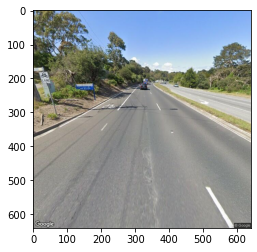

Instructions for updating:
Use `tf.cast` instead.


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node center_net_hourglass_feature_extractor/hourglass_network/input_downsample_block/convolutional_block/conv2d/Conv2D (defined at C:\Users\User\TensorFlow\models\research\object_detection\models\keras_models\hourglass_network.py:94) ]] [Op:__inference_detect_fn_14621]

Errors may have originated from an input operation.
Input Source operations connected to node center_net_hourglass_feature_extractor/hourglass_network/input_downsample_block/convolutional_block/conv2d/Conv2D:
 center_net_hourglass_feature_extractor/hourglass_network/input_downsample_block/convolutional_block/zero_padding2d/Pad (defined at C:\Users\User\TensorFlow\models\research\object_detection\models\keras_models\hourglass_network.py:93)

Function call stack:
detect_fn


In [20]:
apply_model('gsv_30204323_10_177_gsv_0.jpg', True)